# FarmVibes.AI Nutrients Heatmap

This notebook demonstrates how to run the heatmap workflow on sentinel imagery by integrating with [Microsoft Azure Data Manager for Agriculture (ADMAg)](https://learn.microsoft.com/en-us/azure/data-manager-for-agri/). The workflow accepts Farmer_ID, Seasonal_Field_ID and Boundary_ID information to download samples of soil properties (such as carbon and nitrogen) from ADMAg, and generate an interpolated heatmap based on the input imagery.


### Conda environment setup
We provide a conda environment with the package requirements to run this notebook. If you do not have conda installed, please follow the instructions from [Conda User Guide](https://docs.conda.io/projects/conda/en/latest/user-guide/index.html).
The conda environment can be created and activated using the commands below:
```
$ conda env create -f ./nutrients.yaml
$ conda activate nutrients
```

### ADMAg environment setup
Microsoft Azure Data Manager for Agriculture requires registration and is available to only approved customers and partners during the preview period. To setup the required environment, please go through the [ADMAg User Guide](https://learn.microsoft.com/en-us/azure/data-manager-for-agri/quickstart-install-data-manager-for-agriculture).



### Useful libraries

Below are the main libraries used for this example and other useful links:
- [NumPy](https://github.com/numpy/numpy) is a python package that provides powerful N-dimensional array object, broadcasting functions and useful linear algebra, Fourier transform, and random number capabilities.
- [pandas](https://github.com/scikit-learn/scikit-learn) is a Python package that provides fast, flexible, and expressive data structures designed to make working with "relational" or "labeled" data both easy and intuitive.
- [rasterio](https://github.com/rasterio/rasterio) is a library for reading and writing geospatial raster data. It is used on torchgeo and rioxarray. It is a good option when reading/writing GeoTIFFs.
- [Scikit-Learn](https://github.com/scikit-learn/scikit-learn) is a Python package for machine learning built on top of SciPy. It Simple and efficient tools for predictive data analysis.
- [Shapely](https://github.com/shapely/shapely) is a library for manipulating geometric shapes.

### Imports & API Client

In [1]:
from datetime import datetime
from vibe_core.client import get_default_vibe_client

from notebook_lib import utils

## Workflow Inputs
Below inputs required for workflow execution to perform ADMAg Authentication and accessing resources. please go through the [ADMAg User Guide](https://learn.microsoft.com/en-us/azure/data-manager-for-agri/quickstart-install-data-manager-for-agriculture).

In [2]:
#URL to access the registered app 
BASE_URL = "<URL>"
# Value uniquely identifies registered application in the Microsoft identity platform.
CLIENT_ID = "<ID>"
# Secret value generated by the app registration process in the Microsoft identity platform.
CLIENT_SECRET = "<SECRET>"
# URL to which the user is redirected to give consent to the app.
AUTHORITY = "<URL>"
# default azure OAuth2 permissions
DEFAULT_SCOPE = "<URL>"

Below inputs required to query the seasonal field information from ADMAg repository

In [3]:
# Farm information
FARM_INFO = {
    "farmer_id": "<farmer_id>",
    "boundary_id": "<boundary_id>",
    "seasonal_field_id": "<seasonal_field_id>"
}

In [4]:
parameters = {
    "base_url": BASE_URL,
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
    "authority": AUTHORITY,
    "default_scope": DEFAULT_SCOPE,
}

seasonal_field_obj = utils.get_seasonal_field(farm_infO=FARM_INFO, parameters=parameters)
FARM_BOUNDARY = seasonal_field_obj.geometry

## Satellite imagery
Below we outline two methods for getting a raster that contains the satellite imagery used to generate the heatmap. Run the appropriate section below to ingest the data according to your preference.

### 1. Use the FarmVibes.AI workfow
FarmVibes.AI has several workflows that will ingest and preprocess data from many sources. We demonstrate how to obtain Sentinel-2 imagery for a desired location (our field boundary) and time range (some time around when the field samples were collected).

In [5]:
START_DATE=datetime(day=30, month=6, year=2022)
END_DATE=datetime(day=2, month=7, year=2022)

In [6]:
# For the farm boundary, the EPSG code for the coordinate system (CRS) must be 4326.
imagery = utils.get_raster_from_cluster_using_geometry(
    farm_boundary=FARM_BOUNDARY,
    time_range=(START_DATE, END_DATE)
)

## Heatmap workflow
The heatmap workflow will run the following tasks:
- Download sensor samples from ADMAg. Accuracy of the heatmap will depend on the number of samples.
- Compute vegetation indices from the provided raster.
- Clip index raster and sensor samples using the field boundary.
- Bin sample values.
- Train a spatial interpolation model using the vegetation index as input and the sample bin as output.
- Predict nutrient for the whole region at the raster resolution.
- Generate shapefiles for each bin from the prediction raster.

The workflow can be customized via several parameters. Their default values and descriptions can be accessed via the client.

In [7]:
client = get_default_vibe_client()
client.document_workflow("farm_ai/agriculture/heatmap_using_classification_admag")

Workflow: farm_ai/agriculture/heatmap_using_classification_admag

Description:

This workflow integrate the ADMAG API to download prescriptions and generate heatmap. The       
    prescriptions are related with farm boundary and the nutrient information. Each prescription    
    represent a sensor sample at a location within a farm boundary.

Sources:

- admag_input (vibe_core.data.farm.ADMAgSeasonalFieldInput): Required inputs to download        
    prescriptions from admag.

- input_raster (vibe_core.data.rasters.Raster): Input raster for index computation.

Sinks:

- result (vibe_core.data.core_types.DataVibe): Zip file containing cluster geometries.

Parameters:

- base_url (default: None): URL to access the registered app

- client_id (default: None): Value uniquely identifies registered application in the Microsoft  
    identity platform. Visit url                                                                    
    https://learn.microsoft.com/en-us/azure/active-directory/develop/quickstart-register-app to     
    register the app.

- client_secret (default: None): Sometimes called an application password, a client secret is a 
    string value your app can use in place of a certificate to identity itself.

- authority (default: None): The endpoint URIs for your app are generated automatically when you
    register or configure your app. It is used by client to obtain authorization from the resource  
    owner

- default_scope (default: None): URL for default azure OAuth2 permissions

- attribute_name (default: C): Nutrient property name in sensor samples geojson file. For       
    example CARBON (C), Nitrogen (N), Phosphorus (P) etc.,

- buffer (default: 3): Offset distance from sample to perform interpolate operations with       
    raster.

- index (default: ndvi): Type of index to be used to generate heatmap. For example - evi, pri   
    etc.,

- bins (default: 4): Possible number of groups used to move value to nearest group using [numpy 
    histogram](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) and to        
    pre-process the data to support model training with classification .

- simplify (default: simplify): Replace small polygons in input with value of their largest     
    neighbor after converting from raster to vector. Accepts 'simplify' or 'convex' or 'none'.

- tolerance (default: 1.0): All parts of a [simplified                                          
    geometry](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.simplify.html) 
    will be no more than tolerance distance from the original. It has the same units as the         
    coordinate reference system of the GeoSeries. For example, using tolerance=100 in a projected   
    CRS with meters as units means a distance of 100 meters in reality.

- data_scale (default: False): Accepts True or False. Default is False. On True, it scale data  
    using [StandardScalar]                                                                          
    (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)   
    from scikit-learn package.  It Standardize features by removing the mean and scaling to unit    
    variance.

- max_depth (default: 50): The maximum depth of the tree. If None, then nodes are expanded until
    all leaves are pure or until all leaves contain less than min_samples_split samples. For more   
    details refer to                                                                                
    (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

- n_estimators (default: 25): The number of trees in the forest. For more details refer to      
    (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

- random_state (default: 100): Controls both the randomness of the bootstrapping of the samples 
    used when building trees (if bootstrap=True) and the sampling of the features to consider when  
    looking for the best split at each node (if max_features < n_features). For more details refer  
    to                                                                                              
    (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Tasks:

- prescriptions: Fetches prescriptions using ADMAg (Microsoft Azure Data Manager for            
    Agriculture).

- soil_sample_heatmap_classification: Utilizes input Sentinel-2 satellite imagery & the sensor  
    samples as labeled data that contain nutrient information (Nitrogen, Carbon, pH, Phosphorus) to 
    train a model using Random Forest classifier. The inference operation predicts nutrients in soil
    for the chosen farm boundary.

## Generating a Nitrogen heatmap
We demonstrate how to generate a nitrogen heatmap using the Enhanced Vegetation Index (EVI). In the provided sample file, the sensor samples have nitrogen information in attribute `N`. Parameters for a workflow run are defined in a dict as shown below.

In [8]:
# input parameters
parameters = {
    "base_url": BASE_URL,
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
    "authority": AUTHORITY,
    "default_scope": DEFAULT_SCOPE,
    "index": "evi",
    "attribute_name": "N",
    "buffer": 3,
    "bins": 4,
    "simplify": "simplify",
    "tolerance": 1,
    "data_scale": True,
}

archive_path = utils.create_heatmap_admag(
        imagery= imagery,
        farm_infO= FARM_INFO,
        parameters = parameters
)

### Output visualization
We use matplotlib and geopandas to display the results of the workflow from the shapefiles. This is a quick way to get a high level view the workflow output. To get a more detailed look, we recommend opening the generated files and input raster in a geographic analysis platform, such as [QGIS](https://www.qgis.org/en/site/). This will allow you to zoom in and more closely examine the results.

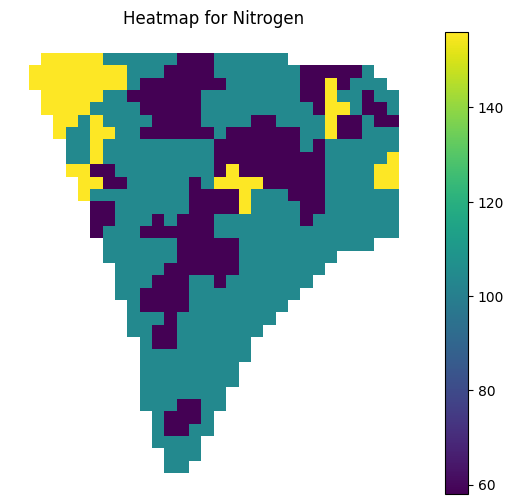

In [9]:
utils.view_output(archive_path, title="Heatmap for Nitrogen")

## Generating a Carbon heatmap
The carbon information is available in the attribute `C`, so we change the parameter accordingly. We also use EVI for this parameter.

In [10]:
# input parameters
parameters = {
    "base_url": BASE_URL,
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
    "authority": AUTHORITY,
    "default_scope": DEFAULT_SCOPE,
    "index": "evi",
    "attribute_name": "C",
    "buffer": 4,
    "bins": 5,
    "simplify": "simplify",
    "tolerance": 1,
    "data_scale": False,
}

archive_path = utils.create_heatmap_admag(
        imagery=imagery, 
        farm_infO=FARM_INFO,
        parameters = parameters
)

Output()

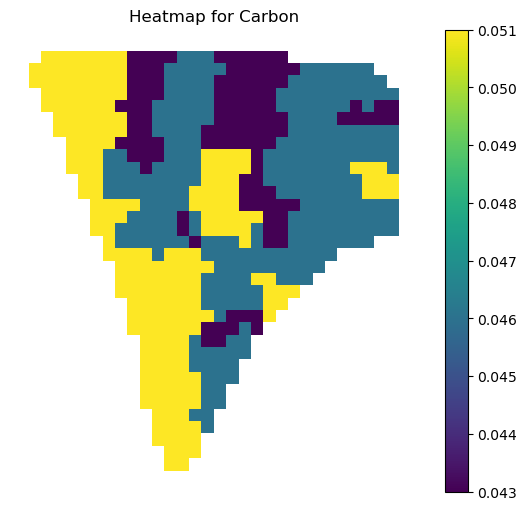

In [11]:
utils.view_output(archive_path, title="Heatmap for Carbon")

## Generating a Phosphorus heatmap
The information about phosphorus is available in the attribute `P`, so we change the parameter accordingly. We also use EVI for this parameter.

In [12]:
# input parameters
parameters = {
    "base_url": BASE_URL,
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
    "authority": AUTHORITY,
    "default_scope": DEFAULT_SCOPE,
    "index":"evi",
    "attribute_name": "P",
    "buffer": 4,
    "bins": 4,
    "simplify": "simplify",
    "tolerance": 1,
    "data_scale": True,
}

archive_path = utils.create_heatmap_admag(
        imagery= imagery,
        farm_infO= FARM_INFO,
        parameters = parameters
)

Output()

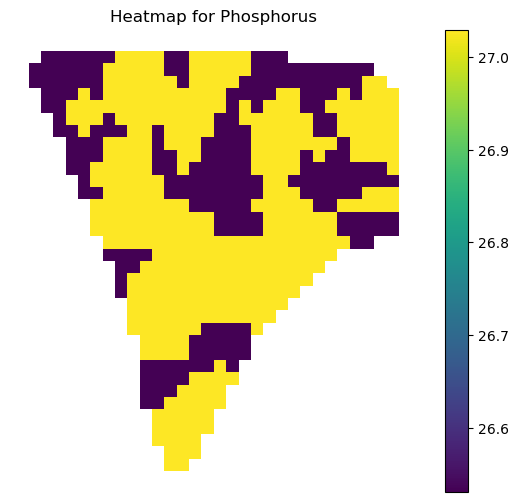

In [13]:
utils.view_output(archive_path, title="Heatmap for Phosphorus")

## Generating a pH heatmap
The information about pH is available in the attribute `pH`, so we change the parameter accordingly. We found that the Photochemical Reflectance Index (PRI) has better correlation with pH values, so we adjust the index as well.

In [14]:
# input parameters
parameters = {
    "base_url": BASE_URL,
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
    "authority": AUTHORITY,
    "default_scope": DEFAULT_SCOPE,
    "index": "pri",
    "attribute_name": "pH",
    "buffer": 3,
    "bins": 3,
    "simplify": "simplify",
    "tolerance": 1,
    "data_scale": False,
}

archive_path = utils.create_heatmap_admag(
        imagery=imagery,
        farm_infO=FARM_INFO,
        parameters = parameters
)

Output()

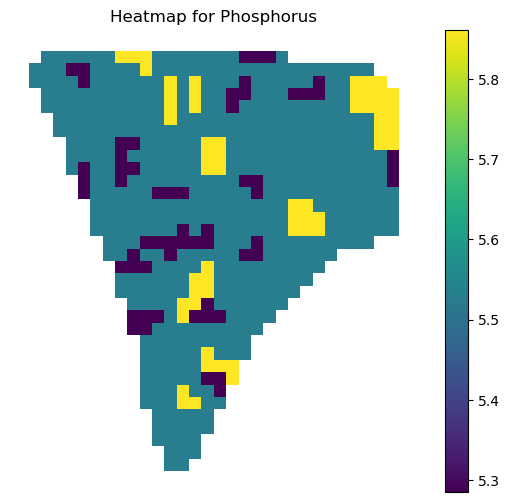

In [15]:
utils.view_output(archive_path, title="Heatmap for Phosphorus")